In [182]:
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [202]:
df_charlotte = pd.read_csv("data/df_charlotte.csv")
df_greensboro = pd.read_csv("data/df_greensboro.csv")
df_nashville = pd.read_csv("data/df_nashville.csv")
df_neworleans = pd.read_csv("data/df_neworleans.csv")
df_raleigh = pd.read_csv("data/df_raleigh.csv")
df_sandiego = pd.read_csv("data/df_sandiego.csv")
df_sanfrancisco = pd.read_csv("data/df_sanfrancisco.csv")

dicto = {'charlotte': df_charlotte, 'greensboro': df_greensboro,'nashville': df_nashville, 'neworleans': df_neworleans,'raleigh': df_raleigh, 'sandiego': df_sandiego,
        'sanfrancisco': df_sanfrancisco}

df = pd.DataFrame(columns = ["name",'total_m', 'total_f', 'stop_rate_m',"stop_rate_f","search_rate_arrest_m","search_rate_arrest_f",
                             "search_rate_contraband_m","search_rate_contraband_f","frisk_rate_m","frisk_rate_f"]) 

/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning:

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.



In [203]:
#we have lost some columns
for name in ["charlotte","greensboro","nashville","neworleans","raleigh","sandiego","sanfrancisco"]:
    data = dicto[name]
    print(data.shape[1])
    

14
14
9
9
14
22
9


In [204]:
#for name in ["charlotte","greensboro","nashville","neworleans","raleigh","sandiego","sanfrancisco"]:
list_name = ["charlotte","greensboro","raleigh"]
for name in list_name:

    data = dicto[name]
    print(name)
    #distribution dataset
    total_m = data[data["subject_sex"] == "male"]
    total_f = data[data["subject_sex"] == "female"]
    #print(total_m.shape[0])
    #print(total_f.shape[0])

    # stop rate 
    # https://www.census.gov/quickfacts/charlottecitynorthcarolina
    population_charlotte = 885708
    population_charlotte_m = int(population_charlotte*0.481)
    population_charlotte_f = population_charlotte - population_charlotte_m

    stop_rate_m = total_m.shape[0] / population_charlotte_m 
    stop_rate_f = total_f.shape[0] / population_charlotte_f
    #print(stop_rate_f)
    #print(stop_rate_m)

    # Search rates
    search_rate_arrest_m = []
    search_rate_arrest_f = []
    search_rate_contraband_m = []
    search_rate_contraband_f = []

    for name_search in ["search_person","search_vehicle"]:
        total_search_m = total_m[total_m[name_search] == True]
        total_search_f = total_f[total_f[name_search] == True]

        search_arrest_m = total_search_m[total_search_m["arrest_made"] == True]
        search_arrest_f = total_search_f[total_search_f["arrest_made"] == True]

        search_rate_arrest_m.append(search_arrest_m.shape[0]/total_search_m.shape[0])
        search_rate_arrest_f.append(search_arrest_f.shape[0]/total_search_f.shape[0])

        #print(" -- "+name_search+" arrest made")
        #print(search_rate_arrest_f)
        #print(search_rate_arrest_m)

        search_contraband_m = total_search_m[total_search_m["contraband_found"] == True]
        search_contraband_f = total_search_f[total_search_f["contraband_found"] == True]

        search_rate_contraband_m.append(search_contraband_m.shape[0]/total_search_m.shape[0])
        search_rate_contraband_f.append(search_contraband_f.shape[0]/total_search_f.shape[0])

        #print(" -- "+name_search+" contraband found")
        #print(search_rate_contraband_f)
        #print(search_rate_contraband_m)

    # frisk rate
    # Search rates
    total_frisk_m = total_m[total_m["frisk_performed"] == True]
    total_frisk_f = total_f[total_f["frisk_performed"] == True]

    frisk_m = total_frisk_m[total_frisk_m["arrest_made"] == True]
    frisk_f = total_frisk_f[total_frisk_f["arrest_made"] == True]

    frisk_rate_m = frisk_m.shape[0]/total_frisk_m.shape[0]
    frisk_rate_f = frisk_f.shape[0]/total_frisk_f.shape[0]

    #print(frisk_rate_f)
    #print(frisk_rate_m)

    ['total_m', 'total_f', 'stop_rate_m',"stop_rate_f","search_rate_arrest_m","search_rate_arrest_f",
                                 "search_rate_contreband_m","search_rate_contreband_f","frisk_rate_m","frisk_rate_f"]

    df = df.append({"name" : name,'total_m' : total_m.shape[0], 'total_f' : total_f.shape[0], 'stop_rate_m' : stop_rate_m,"stop_rate_f" : stop_rate_f,"search_rate_arrest_m" : search_rate_arrest_m ,
                    "search_rate_arrest_f" : search_rate_arrest_f,"search_rate_contraband_m" : search_rate_contraband_m,"search_rate_contraband_f" : search_rate_contraband_f,
                    "frisk_rate_m" : frisk_rate_m,"frisk_rate_f" : frisk_rate_f},  
                    ignore_index = True) 

print(df)

charlotte
greensboro
raleigh
         name total_m total_f  stop_rate_m  stop_rate_f  \
0   charlotte   80116   12762     0.188055     0.027763   
1  greensboro   26884    5051     0.063104     0.010988   
2     raleigh   27555    5735     0.064679     0.012476   

                         search_rate_arrest_m  \
0  [0.44922666666666666, 0.39844598546244464]   
1   [0.32565118233105267, 0.3064874248112712]   
2   [0.5180280180662941, 0.46631890248911523]   

                        search_rate_arrest_f  \
0  [0.5219909502262443, 0.41640838650865997]   
1   [0.38039304269256835, 0.329728536746855]   
2    [0.595688847235239, 0.5224489795918368]   

                     search_rate_contraband_m  \
0               [0.26692, 0.2816999470855265]   
1  [0.30236466210538954, 0.31056477332364457]   
2  [0.15601316696011636, 0.16639283660560256]   

                    search_rate_contraband_f  frisk_rate_m  frisk_rate_f  
0   [0.257737556561086, 0.28003646308113034]      0.167328      0.176923

In [205]:
#hit rate

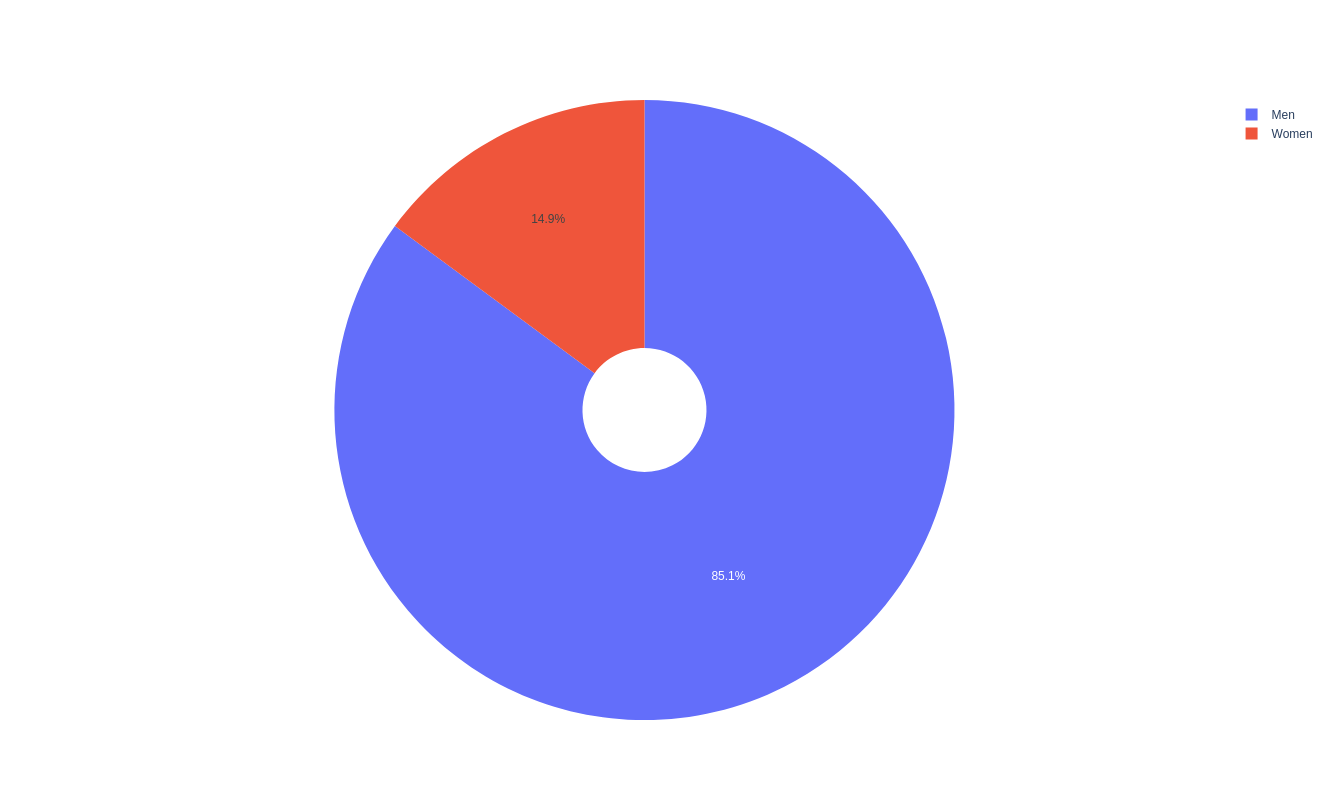

In [213]:
#first plot ,show % men women in our data
labels = ['Women','Men']
values = [df["total_f"].sum(), df["total_m"].sum()]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.2)])
fig.update_layout(
        autosize=False,
        paper_bgcolor='rgba(0,0,0,0)',
        width=800,
        height=800,
        dragmode = False,
    )
fig.show()

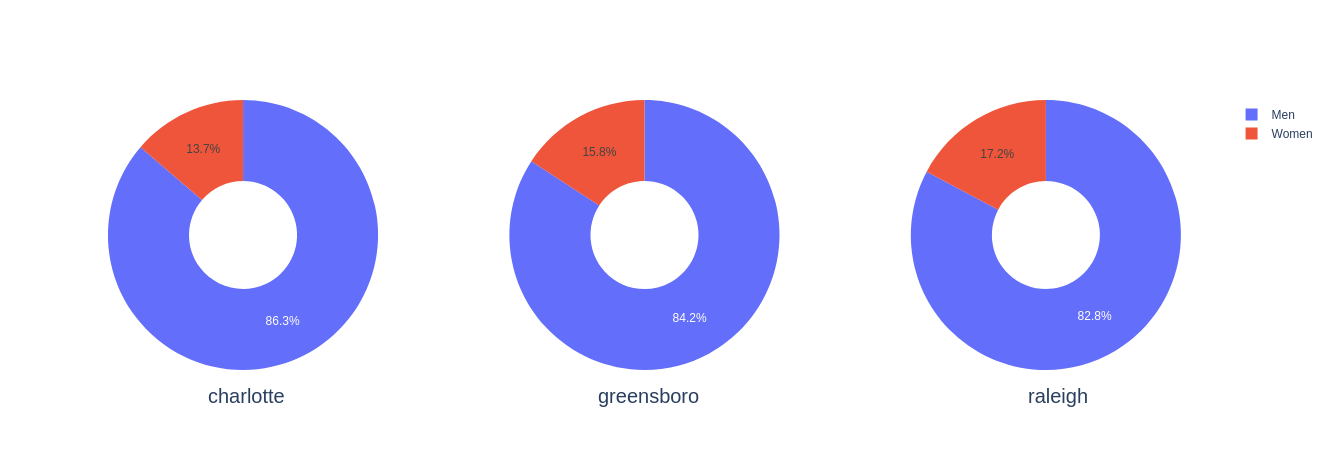

In [223]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'}]])
for i in range(len(list_name)):
    fig.add_trace(go.Pie(labels=labels, values=[df["total_f"][i],df["total_m"][i]], name=list_name[i]),1, 1+i)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

annotation_circle = []
for i in range(len(list_name)):
    annotation_circle.append(dict(text=list_name[i], x=1/9+i*1/2.55, y=-0.15, font_size=20, showarrow=False))
    
fig.update_layout(
    # Add annotations in the center of the donut pies.
    paper_bgcolor='rgba(0,0,0,0)',
    annotations=annotation_circle)
fig.show()

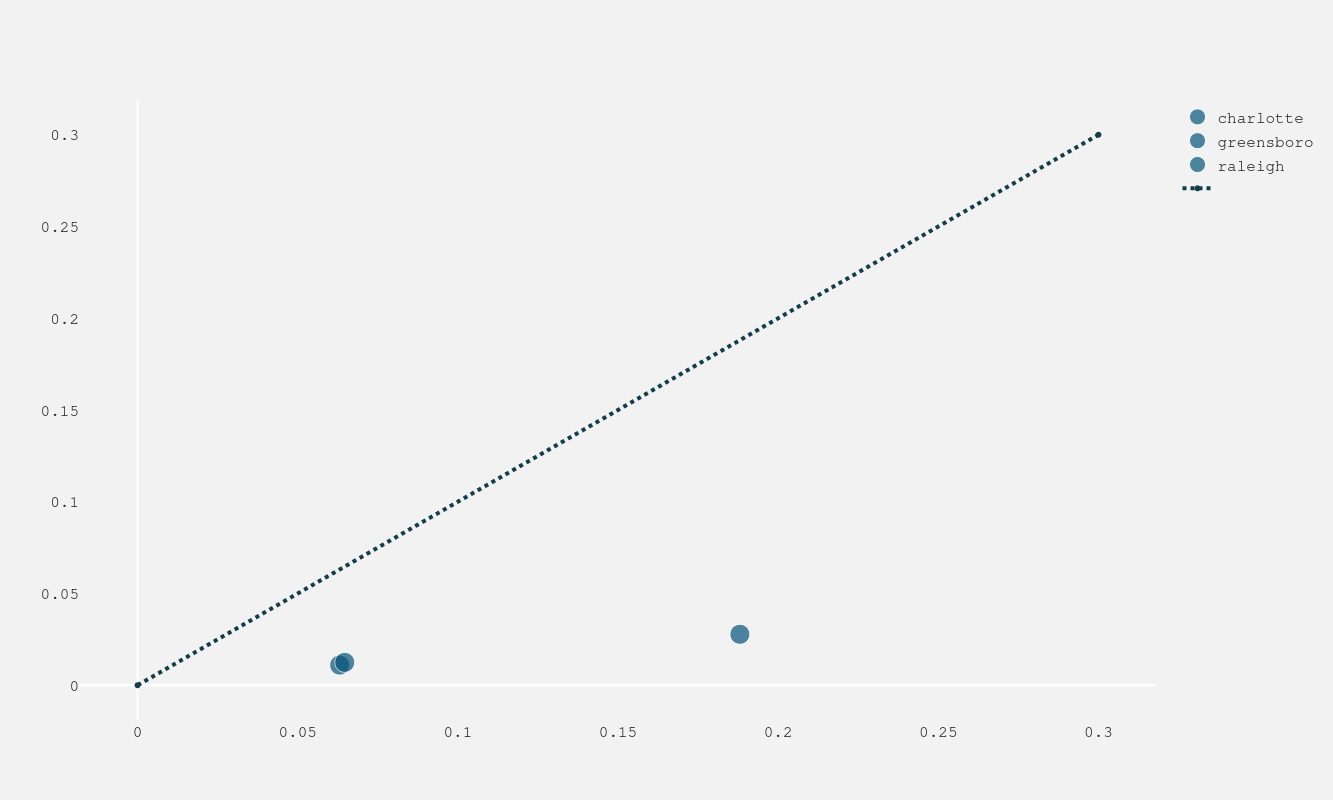

In [249]:
#stop rate
fig = go.Figure()
"""
fig = go.Figure(data=[go.Scatter(
    x=df["stop_rate_m"], y=df["stop_rate_f"],
    mode='markers',
    marker_size=[20,20,20,20,20,20,20,20,20,20])
])"""

marker_var =dict(
        color=['#06547A'],
        opacity=[0.7],
    )

for i in range(len(list_name)):
    fig.add_trace(go.Scatter(x=[df["stop_rate_m"][i]], y=[df["stop_rate_f"][i]],mode='markers', marker=marker_var ,name=list_name[i], marker_size=[20,20,20,20,20,20,20,20,20,20]))

    
color = "#282A2D"

fig.add_trace(go.Scatter(x=[0,0.3], y=[0,0.3], name='',line=dict(color='#143D49', width=4,dash='dot')))
fig.update_layout(
        font = dict(size=16, family='Courier', color=color),
        paper_bgcolor='#F2F2F2',
        plot_bgcolor='rgba(0,0,0,0)',
        autosize=False,
        width=800,
        height=800,
        dragmode = False,
    )


fig.update_xaxes(gridcolor = 'rgba(25, 229, 229,0)',title_font = dict(size=10, family='Courier', color=color))
fig.update_yaxes(gridcolor = 'rgba(255, 229, 229,0)',title_font = dict(size=10, family='Courier', color=color))

fig.show()